# **Import all libraries**

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import ImageFile
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# **Hyperparameter**

In [5]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3) 
LEARNING_RATE = 0.00001

In [6]:
def plot_image(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()

In [7]:
def evaluate_model(model, validation_generator, title):
    """
    Evaluates model predictions and generates a confusion matrix visualization.

    Parameters:
    - model: Trained model used for predictions.
    - generator: Validation or test data generator.
    - class_indices: Dictionary mapping class names to indices.
    - title (str): Title for the confusion matrix plot.

    Returns:
    - conf_matrix (numpy.ndarray): The computed confusion matrix.
    """

    
    predicted_probabilities = model.predict(validation_generator, verbose=1)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    true_classes = validation_generator.classes 

    print(f"True classes length: {len(true_classes)}")
    print(f"Predicted classes length: {len(predicted_classes)}")

    if len(true_classes) == len(predicted_classes):
        conf_matrix = confusion_matrix(true_classes, predicted_classes)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(title)
        plt.show()
    else:
        print("Mismatch in the number of samples between true classes and predicted classes.")

In [8]:
def generate_classification_report(model, generator, class_indices):
    """
    Generates a binary classification report for model predictions.

    Parameters:
    - model: Trained model used for predictions.
    - generator: Validation or test data generator.
    - class_indices: Dictionary mapping class names to indices.

    Returns:
    - report (str): The classification report as a string.
    """
    predicted_probabilities = model.predict(generator, verbose=1)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    true_classes = generator.classes

    report = classification_report(true_classes, predicted_classes, target_names=class_indices.keys())
    
    return report

# **Callbacks**

In [23]:
checkpoint = ModelCheckpoint(
    filepath='best_face_shape_model.keras',      
    monitor='val_loss',            
    save_best_only=True,           
    mode='min',                    
    verbose=1                      
)

# **Load Dataset**

In [9]:
dataset_path = '/kaggle/input/face-shape-oval-round-square/FaceShape 3 Classes'

print('List dir:')
for file in os.listdir(dataset_path):
  print(file)

List dir:
testing_set
training_set


In [10]:
train_dir = os.path.join(dataset_path, 'training_set')
test_dir = os.path.join(dataset_path, 'testing_set')

**Set Pillow to load truncated images**

In [11]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# **Data Preprocessing & Augmentation**

In [12]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range=0.2,  
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical',
                                              color_mode='rgb',
                                              target_size = TARGET_SIZE,
                                              shuffle = False)     

validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                    batch_size  = BATCH_SIZE,
                                                    class_mode  = 'categorical',
                                                    color_mode='rgb',
                                                    target_size = TARGET_SIZE,
                                                    shuffle = False)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


# **Modeling**

**VGG16**

In [17]:
vgg16_model = VGG16(
    input_shape=(224, 224, 3),           
    include_top=False,                   
    weights='imagenet',
    pooling='max'
)

for layer in vgg16_model.layers[:-4]: 
    layer.trainable = False

In [18]:
x = Flatten()(vgg16_model.output) 
x = Dense(256, activation='mish')(x)  
x = Dropout(0.3)(x) 
x = Dense(3, activation='softmax')(x) 


tl1_model = Model(inputs=vgg16_model.input, outputs=x)

tl1_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE, epsilon=1e-07),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
tl1_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 4,851,715 (18.51 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [19]:
history = tl1_model.fit(
    train_generator,
    validation_data=validation_generator,  
    epochs=20,
    verbose=2)

Epoch 1/20
75/75 - 45s - 606ms/step - accuracy: 0.3058 - loss: 1.3911 - val_accuracy: 0.3517 - val_loss: 1.1411
Epoch 2/20
75/75 - 39s - 518ms/step - accuracy: 0.3442 - loss: 1.2401 - val_accuracy: 0.4117 - val_loss: 1.0755
Epoch 3/20
75/75 - 39s - 520ms/step - accuracy: 0.3650 - loss: 1.2018 - val_accuracy: 0.4233 - val_loss: 1.0517
Epoch 4/20
75/75 - 38s - 511ms/step - accuracy: 0.4100 - loss: 1.1125 - val_accuracy: 0.4617 - val_loss: 1.0552
Epoch 5/20
75/75 - 39s - 514ms/step - accuracy: 0.4146 - loss: 1.1014 - val_accuracy: 0.4867 - val_loss: 1.0182
Epoch 6/20
75/75 - 39s - 520ms/step - accuracy: 0.4633 - loss: 1.0569 - val_accuracy: 0.4983 - val_loss: 1.0039
Epoch 7/20
75/75 - 38s - 512ms/step - accuracy: 0.4979 - loss: 1.0079 - val_accuracy: 0.4933 - val_loss: 1.0264
Epoch 8/20
75/75 - 39s - 513ms/step - accuracy: 0.5179 - loss: 0.9901 - val_accuracy: 0.5383 - val_loss: 0.9567
Epoch 9/20
75/75 - 39s - 515ms/step - accuracy: 0.5200 - loss: 0.9727 - val_accuracy: 0.5450 - val_loss:

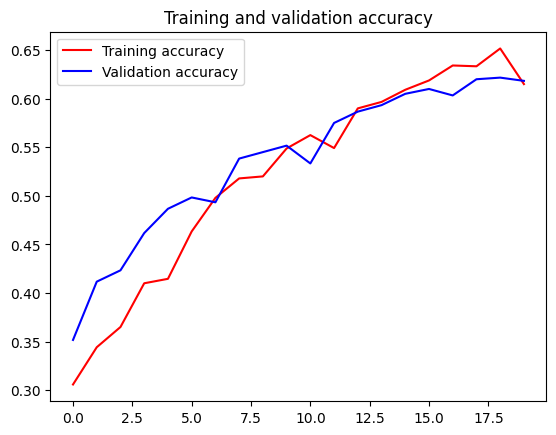

<Figure size 640x480 with 0 Axes>

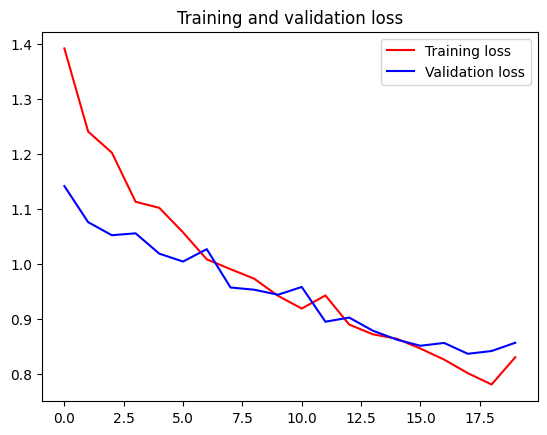

<Figure size 640x480 with 0 Axes>

In [20]:
plot_image(history)

**Add 30 more epochs to reduce the loss.**

In [24]:
history = tl1_model.fit(
    train_generator,
    validation_data=validation_generator,  
    epochs=30,
    verbose=2,
    callbacks=[checkpoint])

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.80733, saving model to best_face_shape_model.keras
75/75 - 40s - 529ms/step - accuracy: 0.6725 - loss: 0.7594 - val_accuracy: 0.6367 - val_loss: 0.8073
Epoch 2/30

Epoch 2: val_loss did not improve from 0.80733
75/75 - 39s - 514ms/step - accuracy: 0.6850 - loss: 0.7337 - val_accuracy: 0.6083 - val_loss: 0.8902
Epoch 3/30

Epoch 3: val_loss did not improve from 0.80733
75/75 - 39s - 514ms/step - accuracy: 0.6883 - loss: 0.7256 - val_accuracy: 0.5900 - val_loss: 0.8396
Epoch 4/30

Epoch 4: val_loss did not improve from 0.80733
75/75 - 39s - 513ms/step - accuracy: 0.7000 - loss: 0.7035 - val_accuracy: 0.6167 - val_loss: 0.8456
Epoch 5/30

Epoch 5: val_loss improved from 0.80733 to 0.80573, saving model to best_face_shape_model.keras
75/75 - 39s - 523ms/step - accuracy: 0.7021 - loss: 0.7022 - val_accuracy: 0.6483 - val_loss: 0.8057
Epoch 6/30

Epoch 6: val_loss improved from 0.80573 to 0.76723, saving model to best_face_shape_model.kera

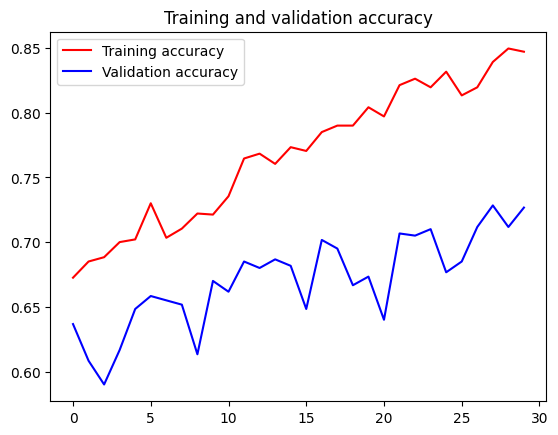

<Figure size 640x480 with 0 Axes>

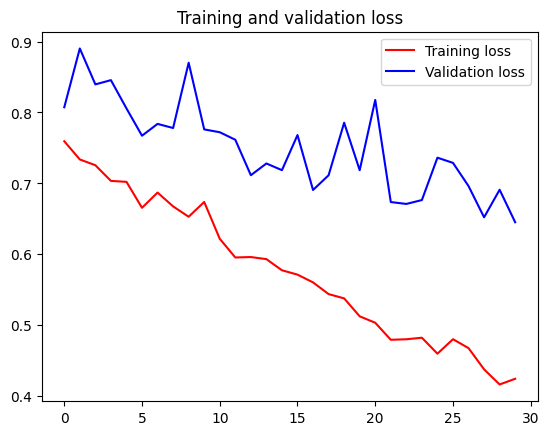

<Figure size 640x480 with 0 Axes>

In [25]:
plot_image(history)

# **Model Evaluation**

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step
True classes length: 600
Predicted classes length: 600


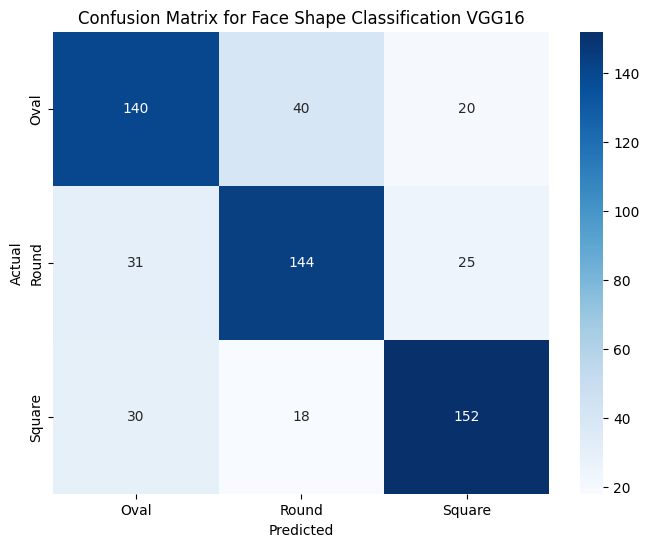

In [26]:
evaluate_model(
    model=tl1_model,
    validation_generator=validation_generator,
    title="Confusion Matrix for Face Shape Classification VGG16"
)

In [27]:
report = generate_classification_report(tl1_model, validation_generator, class_indices=validation_generator.class_indices)
print(report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step
              precision    recall  f1-score   support

        Oval       0.70      0.70      0.70       200
       Round       0.71      0.72      0.72       200
      Square       0.77      0.76      0.77       200

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.73      0.73      0.73       600



# **Save Model**

In [ ]:
# tl1_model.save('fs_model.h5')